In [1]:
!pip3 install -Uqq fastai fastbook

     |████████████████████████████████| 194kB 23.1MB/s 
     |████████████████████████████████| 727kB 32.4MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 1.2MB 44.0MB/s 
     |████████████████████████████████| 61kB 11.3MB/s 


In [2]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
import pathlib
from fastai.vision.all import *
from fastai.data.all import *

In [4]:
# the path to the images:
chrono_images_path = pathlib.Path("/content/gdrive/MyDrive/images")

In [92]:
# Function get the y label as float
regex = r".*\/.+-.+-(.*).jpg"
def img_to_price(f):
    match = re.search(regex, str(f))
    price = float(match.group(1))
    return price

In [93]:
img_to_price(chrono_images_path/'gucci'/'gucci-1-1098.jpg')

1098.0

In [94]:
# Creating the DataBlock:
# .*\/.+-.+-(.*).jpg
chrono = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_items=get_image_files,
    get_y=img_to_price,
    splitter=RandomSplitter(seed=42),
    item_tfms=[Resize(size=210)],
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)] 
)

In [95]:
# Summary of the DataBlock:
chrono.summary(chrono_images_path)

Setting-up type transforms pipelines
Found 3926 items
2 datasets of sizes 3141,785
Setting up Pipeline: PILBase.create
Setting up Pipeline: img_to_price -> RegressionSetup -- {'c': None}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/gdrive/MyDrive/images/jaegerlecoultre/jaegerlecoultre-6-173500.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=210x210
  Pipeline: img_to_price -> RegressionSetup -- {'c': None}
    starting from
      /content/gdrive/MyDrive/images/jaegerlecoultre/jaegerlecoultre-6-173500.jpg
    applying img_to_price gives
      173500.0
    applying RegressionSetup -- {'c': None} gives
      tensor(173500.)

Final sample: (PILImage mode=RGB size=210x210, tensor(173500.))


Found 3926 items
2 datasets of sizes 3141,785
Setting up Pipeline: PILBase.create
Setting up Pipeline: img_to_price -> RegressionSetup -- {'c': None}
Setting up after_item: Pipeline: Resize -- {'size': (210, 210), 'method': 'crop', 'pad_mode': 'refl

In [96]:
# creating the dataset:
dls = chrono.dataloaders(chrono_images_path, bs=64)

In [97]:
# Number of records:
dls.train.n, dls.valid.n

(3141, 785)

In [73]:
# getting the batches:
valid_batch_one = dls.valid.one_batch()
train_batch_one = dls.train.one_batch()

In [98]:
# looking at the y values of the first batch
xb, yb = dls.train.one_batch()
print(yb)

tensor([ 37595.,  88000.,   7493.,  65750.,  45950.,   8600.,   3250.,  17160.,   7995.,   5300.,   8500.,  24250.,    850.,   3299.,   5999.,    500.,   1346.,  23250.,   3400.,   7938.,   5000.,
          2650.,  89900.,  13500.,   8279.,  20644., 105000., 102000.,  37750.,   3562., 279295., 210000.,  10150.,   6550.,   6760.,  17500.,  13499.,   2999.,  45888.,   7529.,   2764.,   7125.,
          5493.,  11000.,    980.,  30000.,   4250.,    789.,   3535.,   1189.,  42000.,   3093.,  34900.,   6375.,   2890.,    607.,   5345.,   8995., 199750.,   6850.,   7795.,   7408.,   6493.,
          1999.], device='cuda:0')


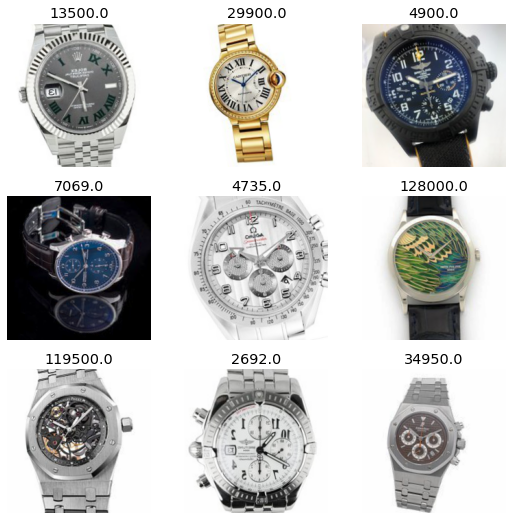

In [100]:
# looking at the first batch of training data:
dls.train.show_batch(b=train_batch_one)

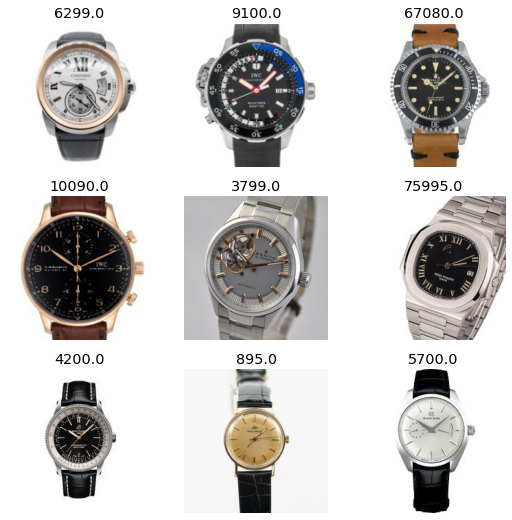

In [101]:
# looking at the first batch of validation set:
dls.valid.show_batch(b=valid_batch_one)

In [102]:
# creating the model

learner = cnn_learner(dls,models.resnet50, loss_func=MSELossFlat(), metrics=mse)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [104]:
# fitting the model:
learner.fit_one_cycle(n_epoch=20)

epoch,train_loss,valid_loss,mse,time
0,2319671296.000000,2752152832.000000,2752152832.000000,05:52
1,2295806720.000000,2751412736.000000,2751412736.000000,00:35
2,2335337472.000000,2750052864.000000,2750052864.000000,00:34
3,2369666048.000000,2748634880.000000,2748634880.000000,00:34
4,2397883136.000000,2745092864.000000,2745092864.000000,00:34
5,2416511232.000000,2744546048.000000,2744546048.000000,00:34
6,2417496320.000000,2740767488.000000,2740767488.000000,00:34
7,2412389120.000000,2735872000.000000,2735872000.000000,00:34
8,2327749120.000000,2736273152.000000,2736273152.000000,00:34
9,2333184768.000000,2731109376.000000,2731109376.000000,00:34


SuggestedLRs(valley=tensor(0.3631))

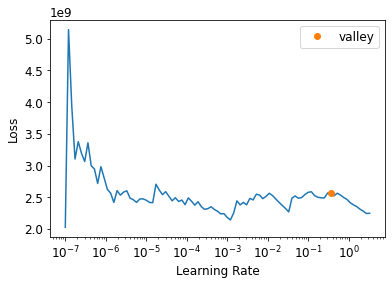

In [106]:
learner.lr_find()

In [107]:
learner.unfreeze()

In [108]:
learner.fit_one_cycle(n_epoch=20, lr_max=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,mse,time
0,2500603136.000000,2722955008.000000,2722955008.000000,00:43
1,2323188480.000000,2729231360.000000,2729231360.000000,00:43
2,2387718144.000000,2710304256.000000,2710304256.000000,00:43
3,2382121984.000000,2600642560.000000,2600642560.000000,00:43
4,2281171712.000000,2705682944.000000,2705682944.000000,00:43
5,2271149312.000000,2406566656.000000,2406566656.000000,00:43
6,2264365568.000000,2558852608.000000,2558852608.000000,00:43
7,2062883456.000000,2001888384.000000,2001888384.000000,00:43
8,1976243456.000000,2056109568.000000,2056109568.000000,00:43
9,1777455872.000000,1856361344.000000,1856361344.000000,00:43


In [110]:
learner.freeze()

In [111]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,mse,time
0,1396940544.000000,1778107904.000000,1778107904.000000,00:34
1,1232159104.000000,1671895168.000000,1671895168.000000,00:34
2,1229851776.000000,1718660864.000000,1718660864.000000,00:34
3,1167461120.000000,1545885184.000000,1545885184.000000,00:34
4,1203558272.000000,1626689024.000000,1626689024.000000,00:34
5,1144408320.000000,1592544896.000000,1592544896.000000,00:34
6,1177438976.000000,1484950784.000000,1484950784.000000,00:34
7,1171858432.000000,1669233920.000000,1669233920.000000,00:34
8,1221769600.000000,1632232960.000000,1632232960.000000,00:34
9,1159509760.000000,1625859840.000000,1625859840.000000,00:34


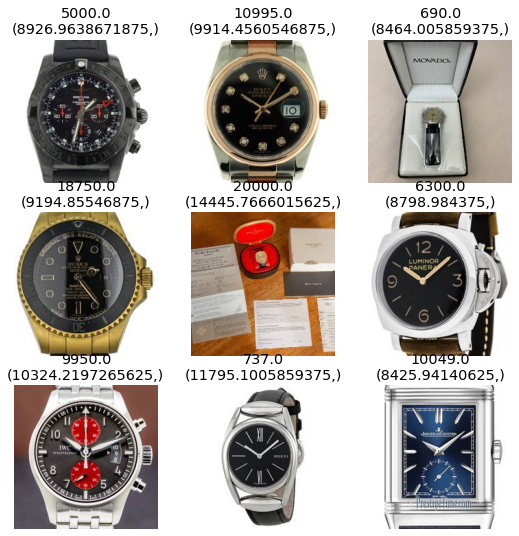

In [112]:
learner.show_results()

In [113]:
# saving the model:
learner.export('regressor_stage1.pkl')

In [114]:
# Creating a resnet34 model:
learner = cnn_learner(dls, arch=resnet34, loss_func=MSELossFlat(), metrics=mae)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [115]:
# fitting the model for 20 cycles:
learner.fit_one_cycle(n_epoch=20)

epoch,train_loss,valid_loss,mae,time
0,2362648064.000000,2752235264.000000,19735.710938,00:21
1,2269212928.000000,2752053760.000000,19735.628906,00:21
2,2352426752.000000,2751337984.000000,19736.707031,00:20
3,2353456896.000000,2750113024.000000,19737.931641,00:20
4,2286320128.000000,2747119616.000000,19709.091797,00:20
5,2317764096.000000,2744720384.000000,19711.851562,00:21
6,2320314624.000000,2742174976.000000,19709.968750,00:21
7,2436153600.000000,2740907008.000000,19712.269531,00:20
8,2361764608.000000,2733484544.000000,19642.326172,00:20
9,2348364288.000000,2731920640.000000,19644.781250,00:21


In [116]:
learner.unfreeze()

In [117]:
learner.fit_one_cycle(n_epoch=30, lr_max=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,mae,time
0,2287373056.000000,2718488832.000000,19580.470703,00:27
1,2410152704.000000,2731418880.000000,19725.050781,00:28
2,2278371328.000000,2724234496.000000,19587.224609,00:27
3,2286147328.000000,2496089344.000000,17199.220703,00:27
4,2281834752.000000,2699906304.000000,19363.972656,00:28
5,2255236096.000000,2592868096.000000,18953.496094,00:27
6,2157321472.000000,2529573120.000000,18030.332031,00:27
7,2104843904.000000,2272965888.000000,16550.576172,00:27
8,1984766080.000000,2051833472.000000,15257.751953,00:27
9,1811181056.000000,2075168768.000000,15191.292969,00:27


In [118]:
learner.freeze()

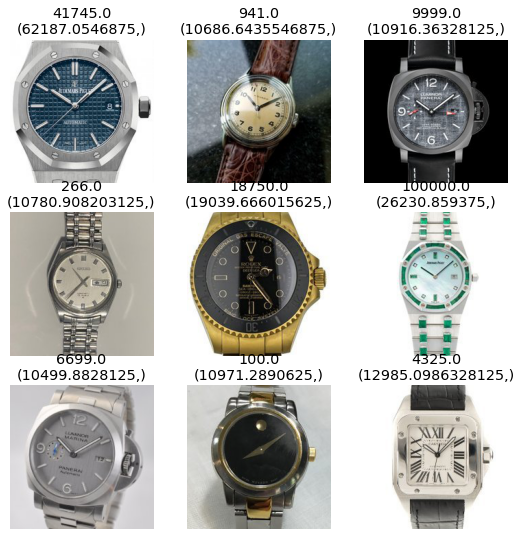

In [119]:
learner.show_results()

In [120]:
# saving the model weights:
learner.save("resnet34_stage1")

Path('models/resnet34_stage1.pth')

In [121]:
learner.freeze()

In [122]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,mae,time
0,792753280.000000,1430561664.000000,15239.258789,00:22
1,758687616.000000,1344294272.000000,14751.694336,00:21
2,768119232.000000,1417775104.000000,15094.304688,00:21
3,813693824.000000,1445524480.000000,15268.247070,00:21
4,728071232.000000,1340321024.000000,14510.342773,00:21
5,746237952.000000,1454141696.000000,15188.524414,00:21
6,736752320.000000,1356675712.000000,14951.275391,00:21
7,727456064.000000,1427107712.000000,15259.011719,00:21
8,719944320.000000,1392340608.000000,15171.122070,00:21
9,726563072.000000,1400851328.000000,15310.234375,00:21


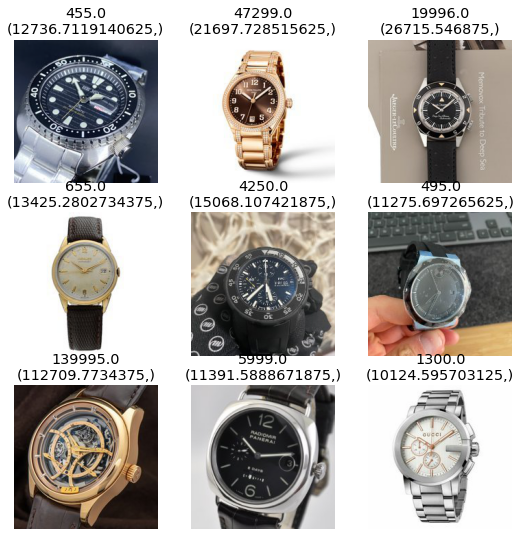

In [123]:
learner.show_results()

In [124]:
learner.export("regressor_stage2.pkl")